## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
import math

In [9]:
import sys
import os

In [10]:
import functools

In [11]:
import torch
import torchvision

In [12]:
from einops import *

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
import networkx as nx

In [15]:
from pathlib import Path

In [16]:
import umap
#Note: VERY HACKY: Manually fixed broken deps install.
import umap.plot
from umap import UMAP

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


## Set up the geotiff loading infra

In [18]:
os.getcwd()

'E:\\Verifiable work on comparing FaceNet to GLCMs'

In [19]:
Path(r'E:\FRDC-ML\src\frdc\conf.py').parents[2]

WindowsPath('E:/FRDC-ML')

In [21]:
ROOT_DIR = Path(r'FRDC-ML').resolve()
LOCAL_DATASET_ROOT_DIR = ROOT_DIR / 'rsc'
LOCAL_BACKEND_DATA_ROOT_DIR = ROOT_DIR / 'backend-rsc'
SECRETS_DIR = ROOT_DIR / '.secrets'
GCS_PROJECT_ID = 'frmodel'
GCS_BUCKET_NAME = 'frdc-scan'
GCS_BACKEND_BUCKET_NAME = 'files-from-backend'

In [24]:
sys.path.append((ROOT_DIR / 'src').__str__())

In [26]:
import frdc
import frdc.load
import frdc.conf

In [27]:
bands = dict(BLUE=frdc.conf.Band.BLUE,
             GREEN=frdc.conf.Band.GREEN,
             RED=frdc.conf.Band.RED,
             RED_EDGE=frdc.conf.Band.RED_EDGE,
             NIR=frdc.conf.Band.NIR)
band_names = ['blue', 'green', 'red', 'red_edge', 'nir']

## Load in our Casuarina data, wr, wg, wb

In [153]:
arr_93deg = rio\
    .open(Path('geotiffs') / '93deg' / 'result_all_bands.tif')\
    .read()
arr_93deg = rearrange(arr_93deg, 'c h w -> h w c')
arr_93deg_wrgb = arr_93deg[:,:,:3]

In [240]:
arr_183deg = rio\
    .open(Path('geotiffs') / '183deg' / 'result_all_bands.tif')\
    .read()
arr_183deg = rearrange(arr_183deg, 'c h w -> h w c')
arr_183deg_wrgb = arr_183deg[:,:,:3]

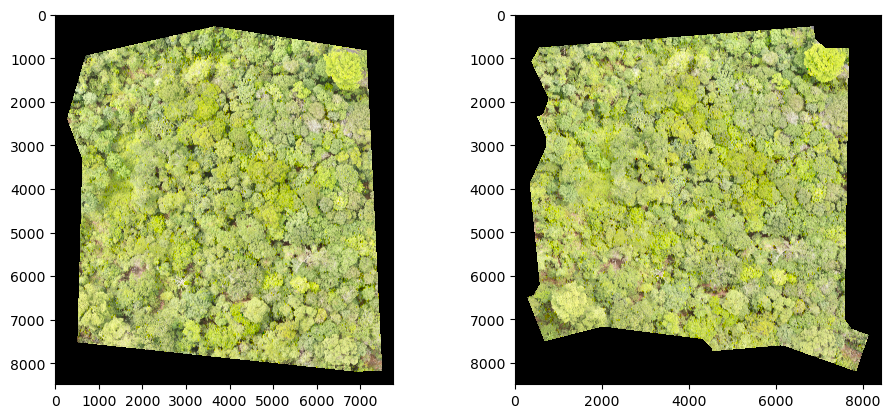

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
ax[0].imshow(arr_93deg_wrgb / 256)
ax[1].imshow(arr_183deg_wrgb / 256)

In [242]:
gc.collect()

188873

## Load in our existing CAMPAU crops

In [234]:
casuarina_bounds_93deg = pd.read_csv('93deg Campnosperma boxes.csv',
                                       names=['name', 'ymin', 'ymax', 'xmin', 'xmax'],
                                       index_col=False)
casuarina_bounds_93deg['src'] = '93deg'
casuarina_bounds_183deg = pd.read_csv('183deg Campnosperma boxes.csv',
                                       names=['name', 'ymin', 'ymax', 'xmin', 'xmax'],
                                       index_col=False)
casuarina_bounds_183deg['src'] = '183deg'
casuarina_bounds = pd.concat((casuarina_bounds_93deg, casuarina_bounds_183deg))
casuarina_bounds = casuarina_bounds.reset_index(drop=True)

In [235]:
casuarina_bounds

name  ymin  ymax  xmin  xmax     src
0  Campnosperma N  4017  4166  4305  4485   93deg
1  Campnosperma S  4583  4702  4242  4421   93deg
2       Palm Tree  4471  4648  3706  3891   93deg
3  Campnosperma N  3833  3984  4717  4901  183deg
4  Campnosperma S  4403  4520  4639  4795  183deg
5       Palm Tree  4289  4450  4162  4334  183deg

In [236]:
names = list(casuarina_bounds['name'].unique())
srcs = list(casuarina_bounds['src'].unique())

## Display existing crops

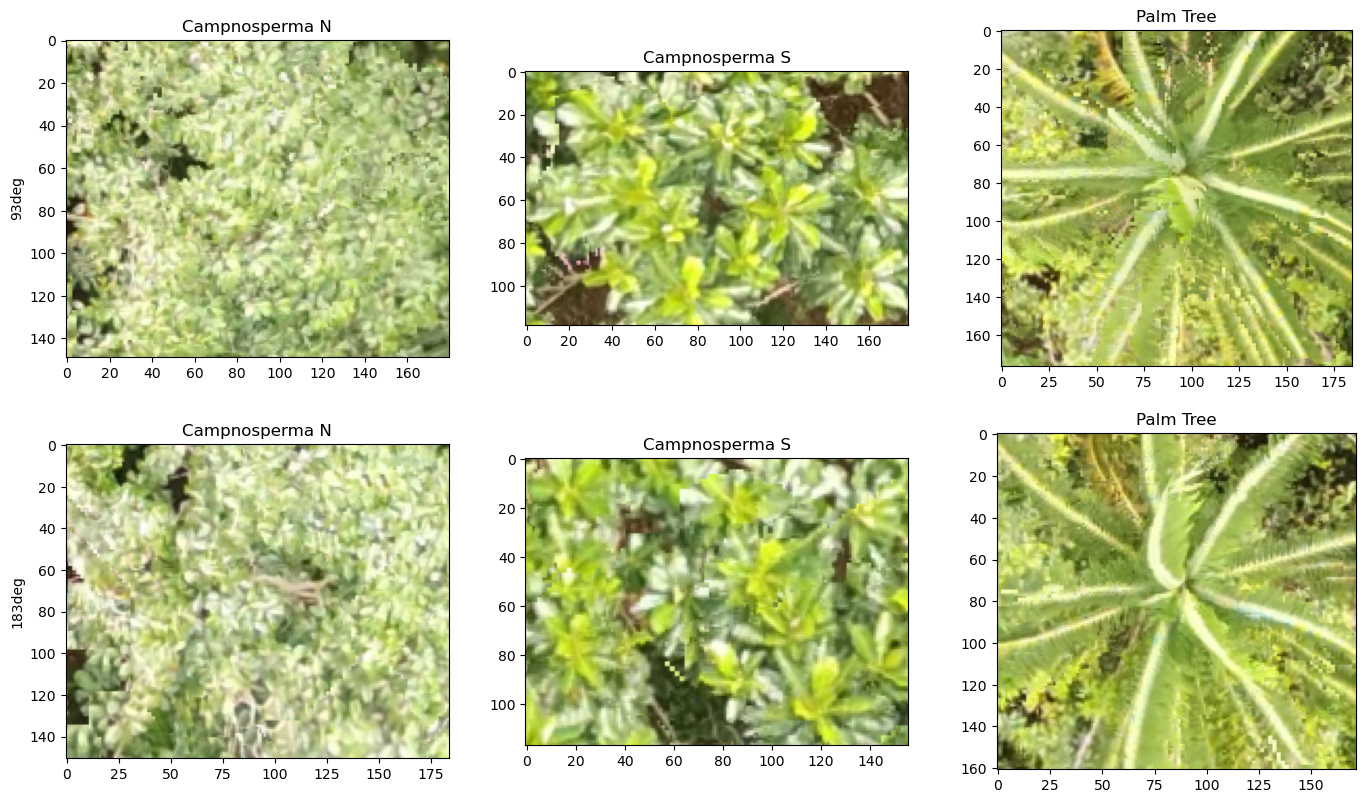

In [243]:
fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
for row, src in zip(ax, srcs):
    row[0].set_ylabel(src)
    for box, name in zip(row, names):
        bounds_row = casuarina_bounds[(casuarina_bounds['name'] == name) & (casuarina_bounds['src'] == src)]
        bounds_row = bounds_row.iloc[0]
        image = arr_93deg_wrgb if src == '93deg' else arr_183deg_wrgb
        crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']] / 255
        box.imshow(crop)
        box.set_title(name)

## Add "Campau E", add Macagi bounds

In [244]:
#casuarina_bounds = casuarina_bounds[casuarina_bounds['name'] != 'Campnosperma S']

In [245]:
#casuarina_bounds

In [246]:
new_bounds = [['src', 'name', 'ymin', 'ymax', 'xmin', 'xmax'],
              ['183deg', 'Campnosperma E', 3306, 3644, 6863, 7276],
              ['183deg', 'macagi top', 1259, 1846, 4600, 5041],
              ['183deg', 'macagi top left', 2207, 2623, 2626, 3200],
              ['183deg', 'macagi middle', 2849, 3096, 4916, 5049],
              ['183deg', 'macagi bottom', 3729, 3976, 3664, 3897],
              ['93deg', 'Campnosperma E', 3501, 3836, 6458, 6810],
              ['93deg', 'macagi top', 1375, 2037, 4117, 4554],
              ['93deg', 'macagi top left', 2393, 2793, 2193, 2709],
              ['93deg', 'macagi middle', 3015, 3279, 4476, 4636],
              ['93deg', 'macagi bottom', 3921, 4196, 3224, 3444]]
new_bounds = pd.DataFrame(new_bounds[1:], columns=new_bounds[0])

In [247]:
new_bounds

src             name  ymin  ymax  xmin  xmax
0  183deg   Campnosperma E  3306  3644  6863  7276
1  183deg       macagi top  1259  1846  4600  5041
2  183deg  macagi top left  2207  2623  2626  3200
3  183deg    macagi middle  2849  3096  4916  5049
4  183deg    macagi bottom  3729  3976  3664  3897
5   93deg   Campnosperma E  3501  3836  6458  6810
6   93deg       macagi top  1375  2037  4117  4554
7   93deg  macagi top left  2393  2793  2193  2709
8   93deg    macagi middle  3015  3279  4476  4636
9   93deg    macagi bottom  3921  4196  3224  3444

In [248]:
casuarina_bounds = pd.concat((casuarina_bounds, new_bounds))

## Display current crops

In [249]:
names = list(casuarina_bounds['name'].unique())
srcs = list(casuarina_bounds['src'].unique())

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


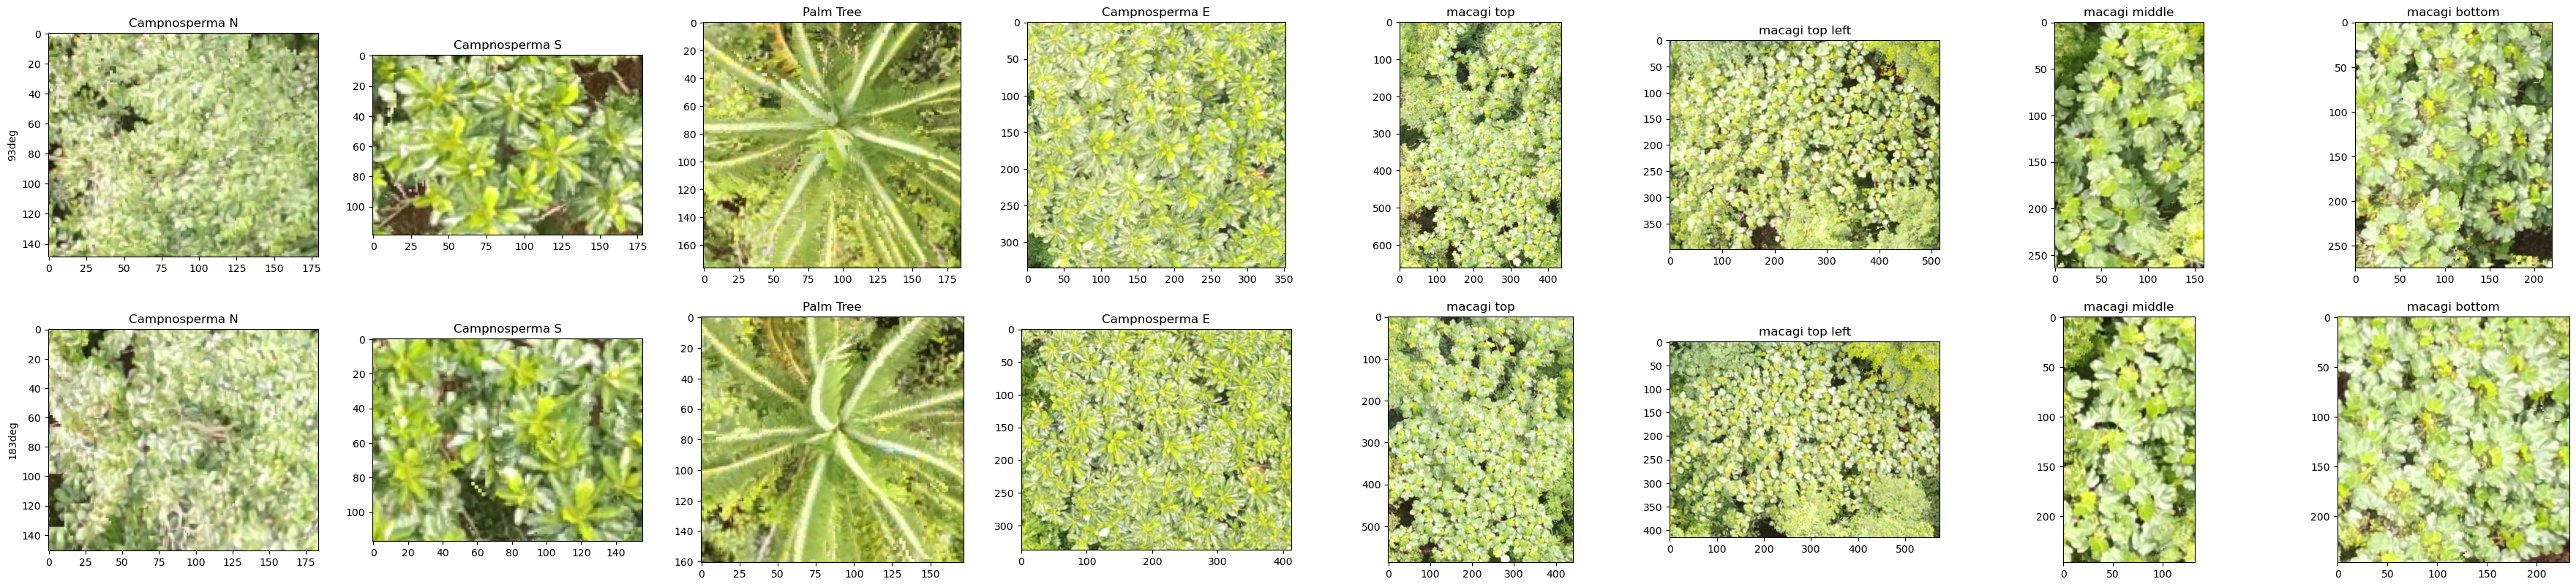

In [250]:
fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
for row, src in zip(ax, srcs):
    row[0].set_ylabel(src)
    for box, name in zip(row, names):
        bounds_row = casuarina_bounds[(casuarina_bounds['name'] == name) & (casuarina_bounds['src'] == src)]
        bounds_row = bounds_row.iloc[0]
        image = arr_93deg_wrgb if src == '93deg' else arr_183deg_wrgb
        crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']] / 255
        box.imshow(crop)
        box.set_title(name)

## Save each crop

In [ ]:
crops = []
for index, row in casuarina_bounds.iterrows():
    name = row['name']
    src = row['src']
    image = arr_93deg if src == '93deg' else arr_183deg
    crop = image[row['ymin']:row['ymax'],row['xmin']:row['xmax']]
    crops.append(crop)
df_casuarina = casuarina_bounds.copy()
df_casuarina['crop'] = crops
del crops

## Display the central 64x64px of each crop

In [252]:
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


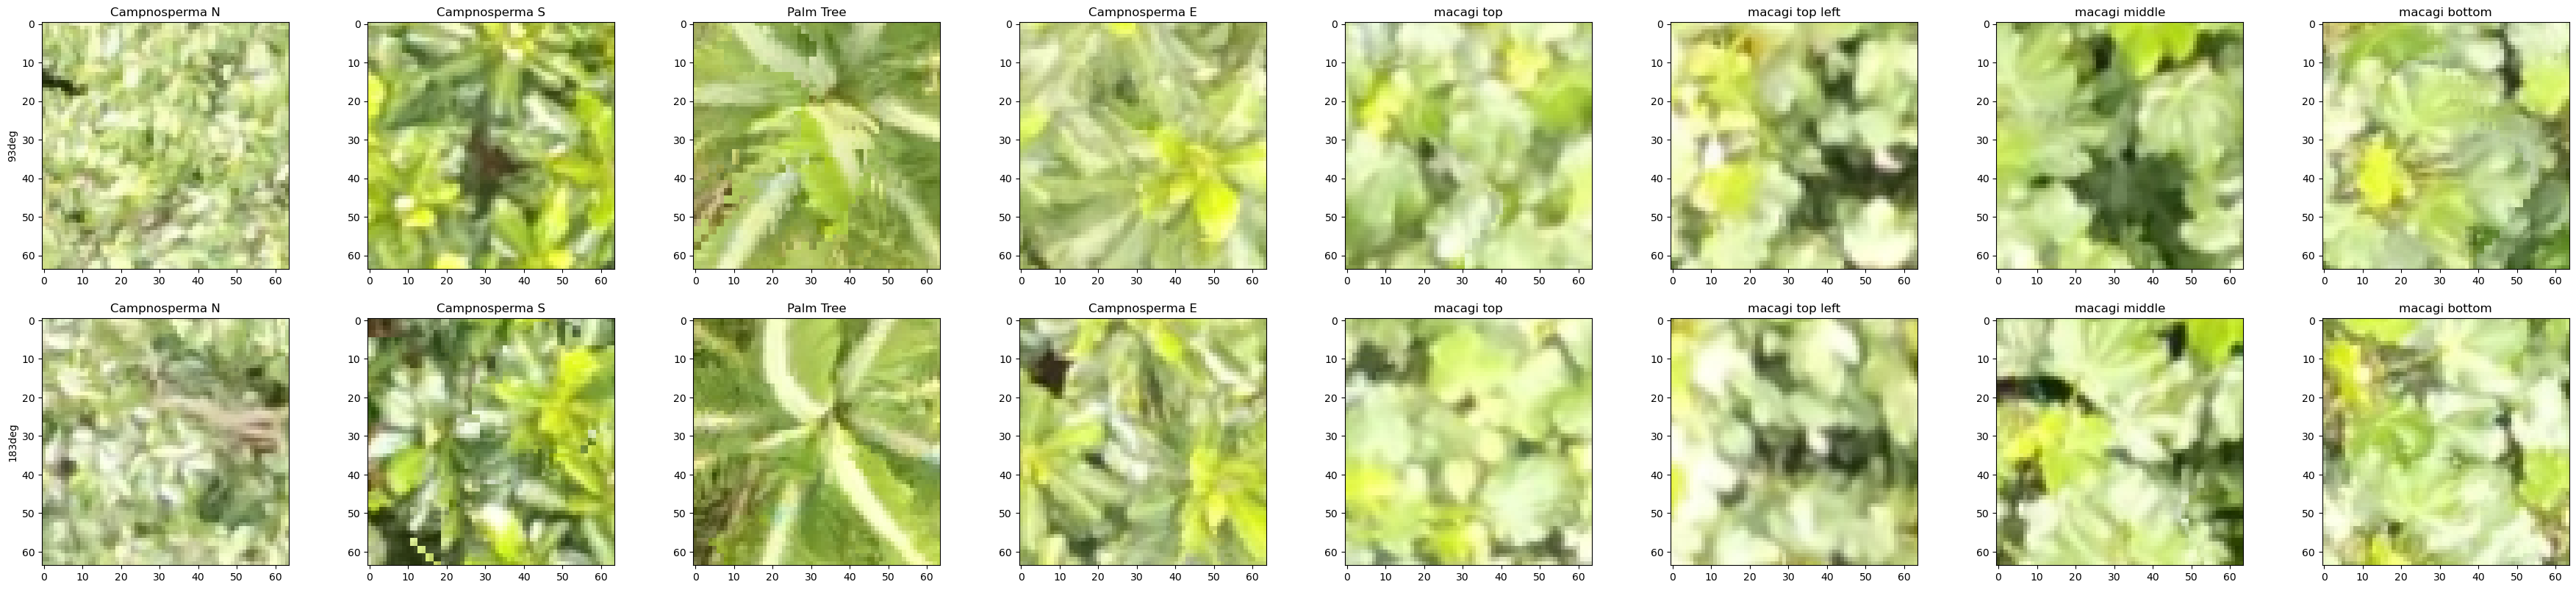

In [331]:
fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
for row, src in zip(ax, srcs):
    row[0].set_ylabel(src)
    for box, name in zip(row, names):
        bounds_row = casuarina_bounds[(casuarina_bounds['name'] == name) & (casuarina_bounds['src'] == src)]
        bounds_row = bounds_row.iloc[0]
        image = arr_93deg_wrgb if src == '93deg' else arr_183deg_wrgb
        crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']] / 255
        crop = crop_center(crop, 64, 64)
        box.imshow(crop)
        box.set_title(name)

## Produce histograms of each crop for comparison

In [324]:
np.nanmax(arr_93deg[:,:,3:6])

7632.859

In [ ]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

In [338]:
def histograms_for_bands(chosen_bands, xlim):
    fig, ax = plt.subplots(nrows:=len(srcs), ncols:=len(names), figsize=(5.6*ncols, 4.8*nrows))
    for row, src in zip(ax, srcs):
        row[0].set_ylabel(src)
        for box, name in zip(row, names):
            bounds_row = casuarina_bounds[(casuarina_bounds['name'] == name) & (casuarina_bounds['src'] == src)]
            bounds_row = bounds_row.iloc[0]
            image = arr_93deg if src == '93deg' else arr_93deg
            crop = image[bounds_row['ymin']:bounds_row['ymax'],bounds_row['xmin']:bounds_row['xmax']]
            crop = crop_center(crop, 64, 64)
            crop = crop[:,:,[bands.index(i) for i in chosen_bands]]
            pixels = crop.reshape((-1, len(chosen_bands)))
            pixels = pd.DataFrame(pixels)
            pixels.columns = chosen_bands
            sns.histplot(
                pixels,
                bins=128,
                palette='Set1',
                stat='density',
                common_norm=False,
                #element='step',
                #fill=True,
                #log_scale=2,
                ax=box)
            box.set_title(name)
            box.set_xlim(*xlim)
    return fig

Text(0.5, 0.98, 'Histograms for widebands')

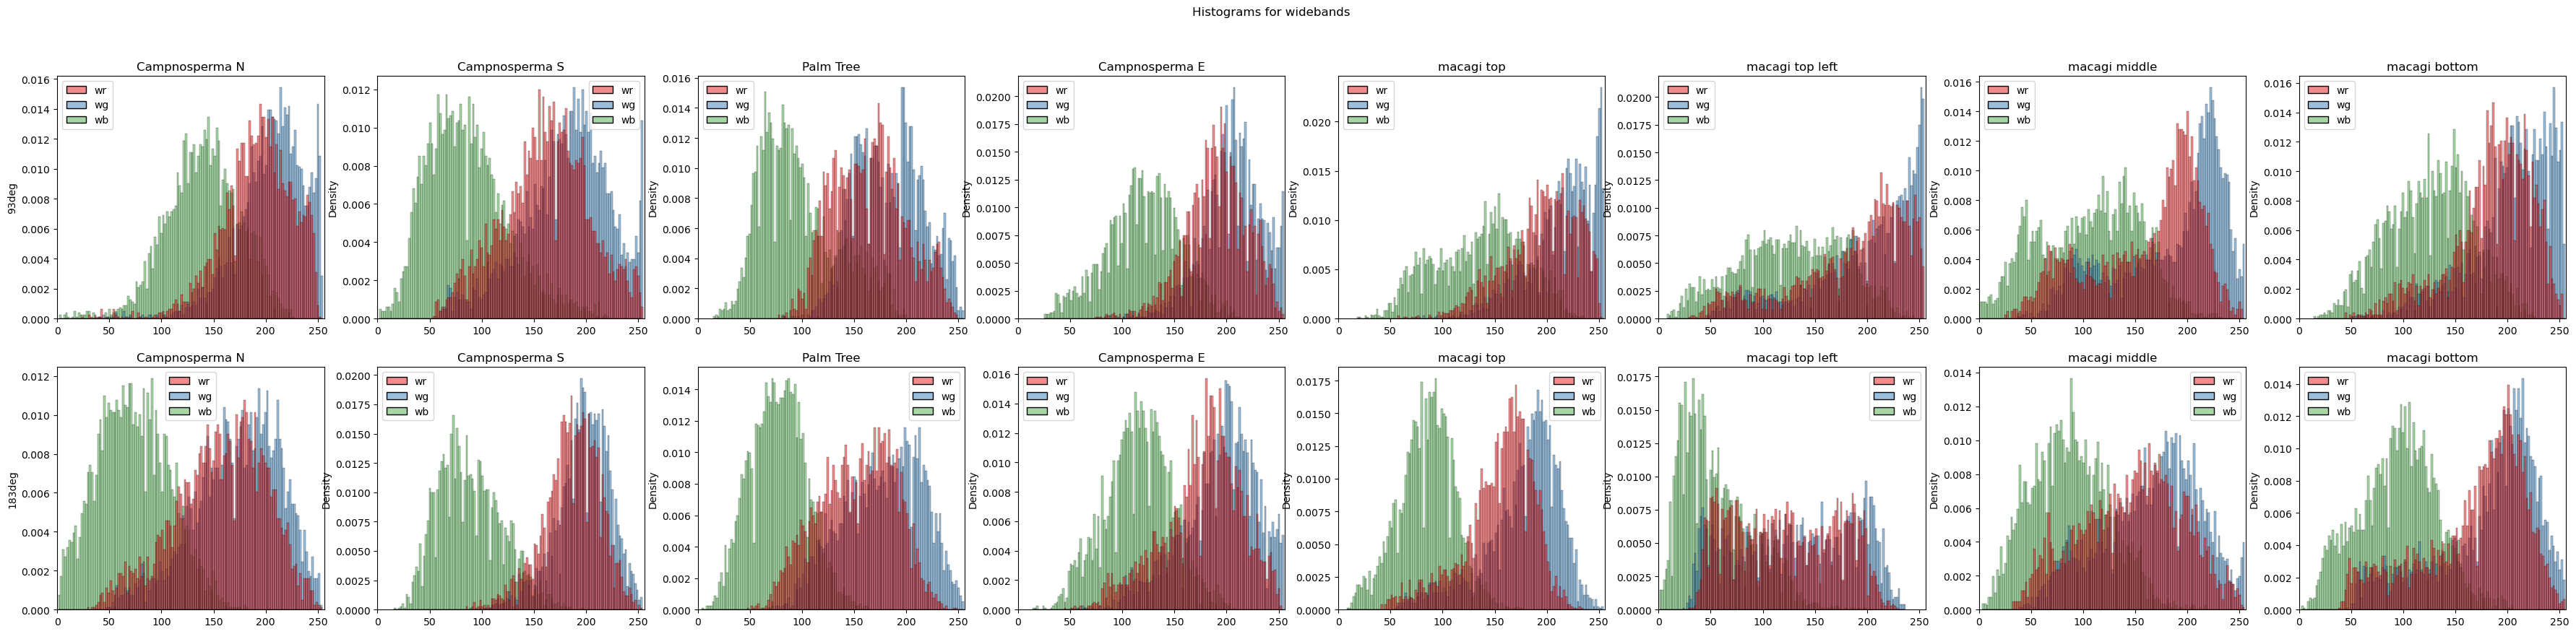

In [341]:
fig = histograms_for_bands(['wr', 'wg', 'wb'], xlim=(0, 256))
fig.suptitle("Histograms for widebands")

Text(0.5, 0.98, 'Histograms for narrowbands')

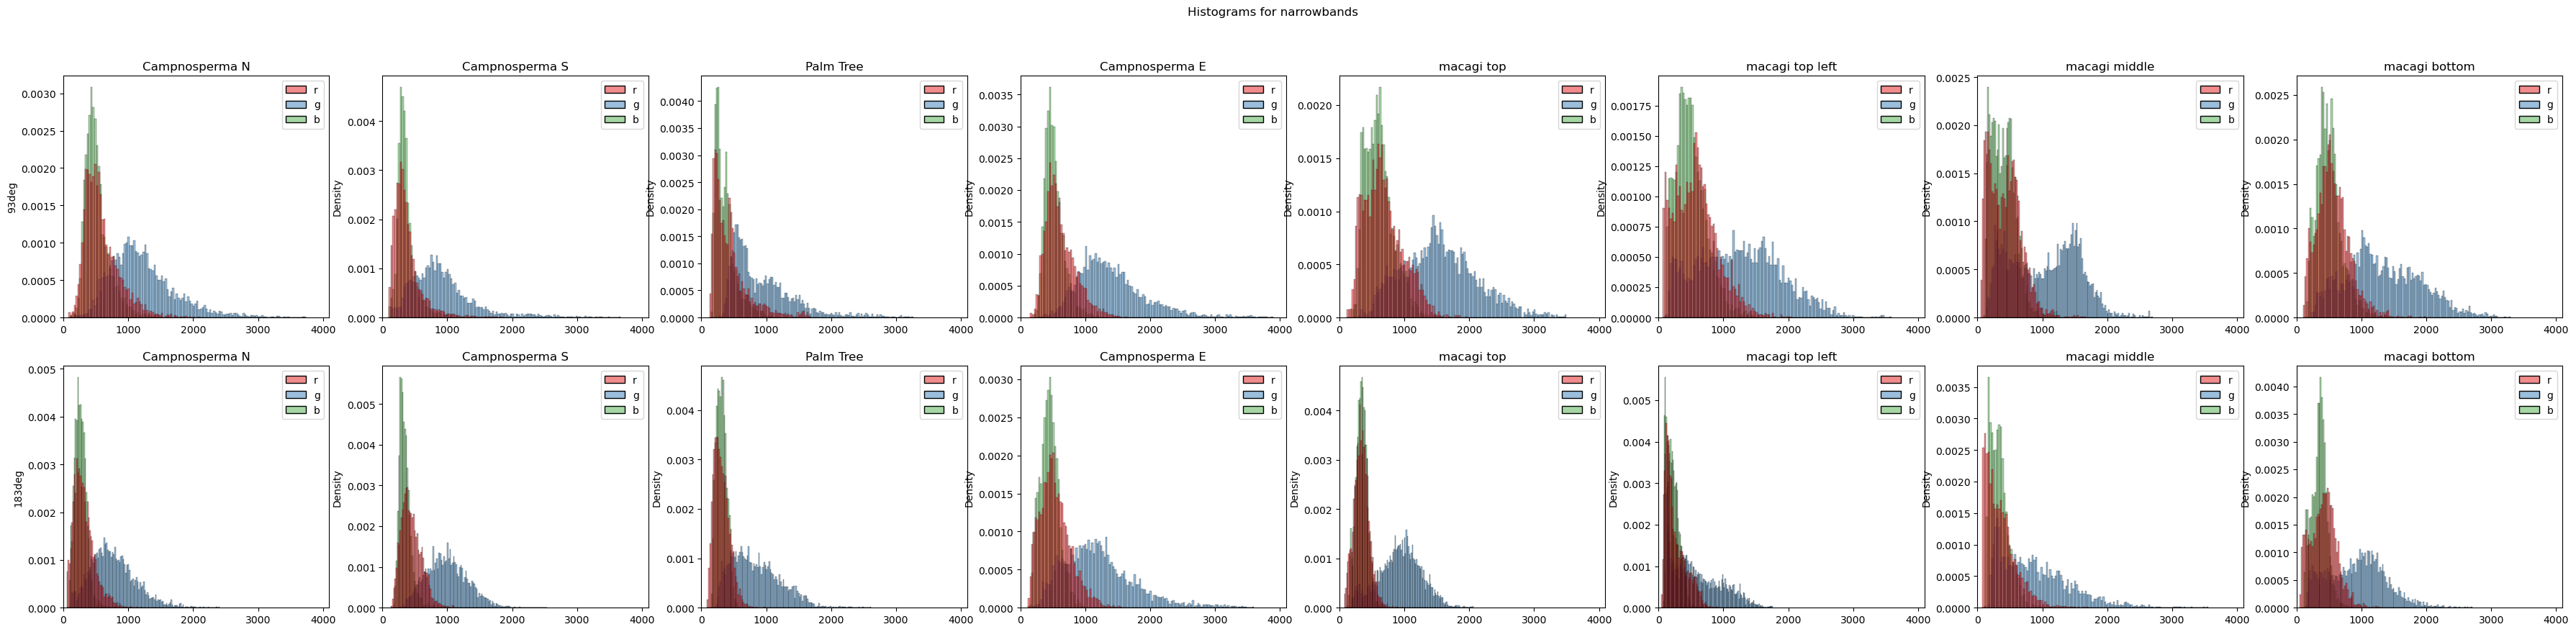

In [342]:
fig = histograms_for_bands(['r', 'g', 'b'], xlim=(0,4096))
fig.suptitle("Histograms for narrowbands")

Text(0.5, 0.98, 'Histograms for nir and red_edge')

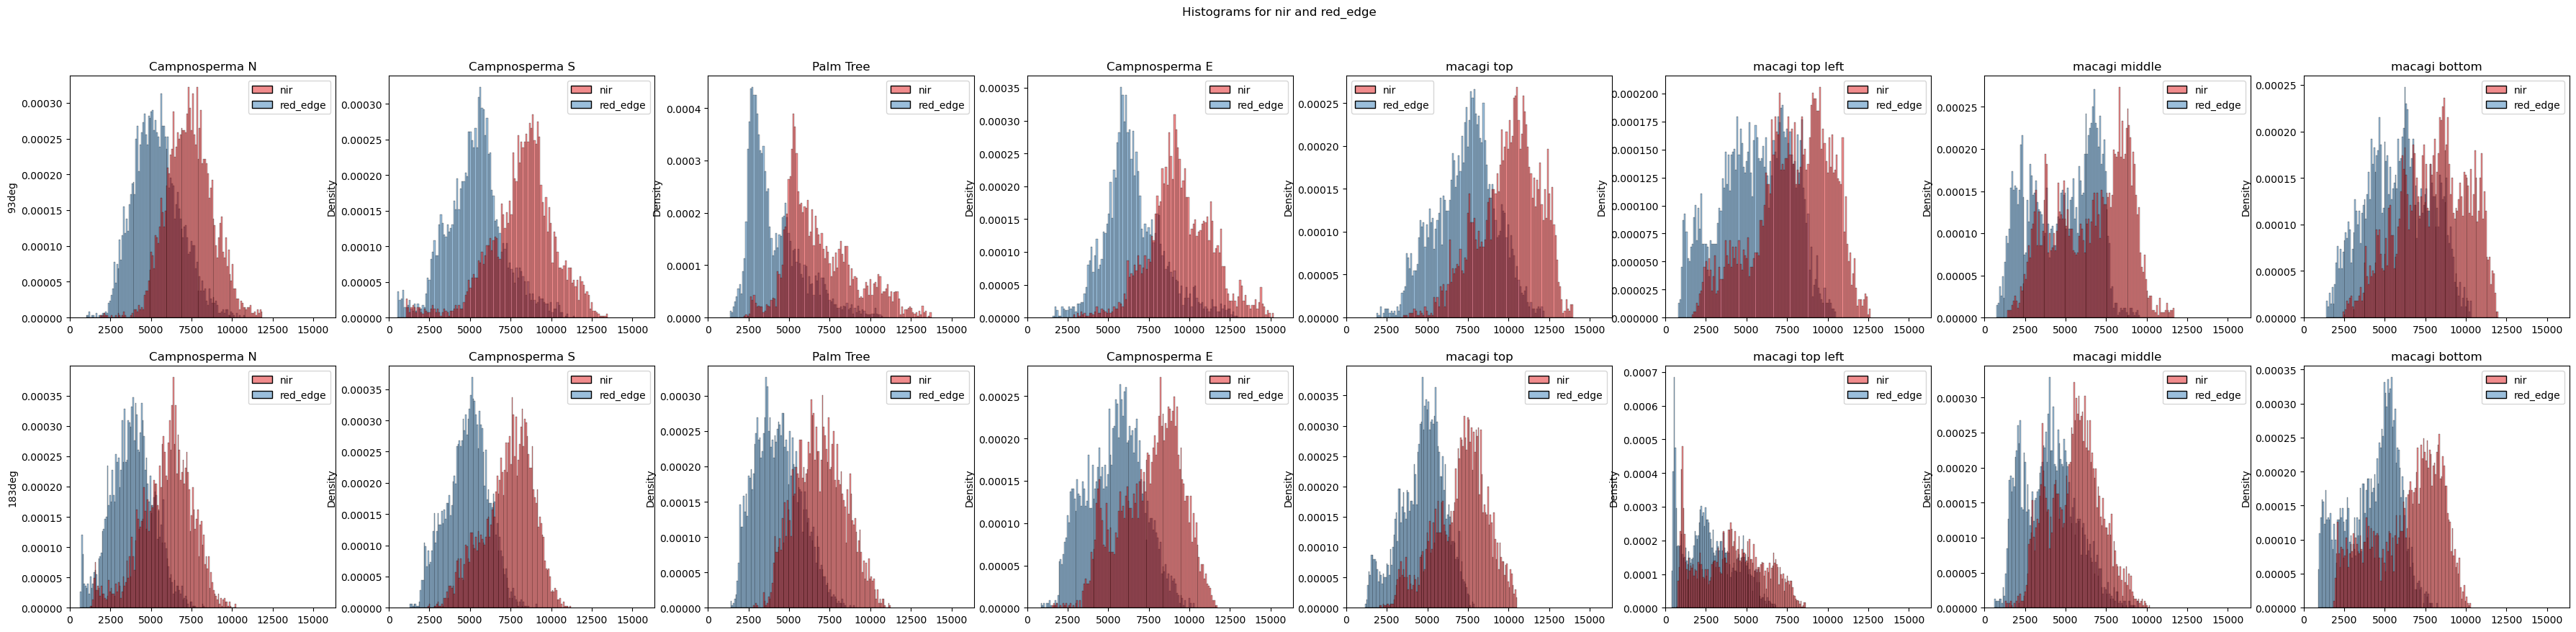

In [345]:
fig = histograms_for_bands(['nir', 'red_edge'], xlim=(0, 16384))
fig.suptitle("Histograms for nir and red_edge")

Text(0.5, 0.98, 'Histograms for ndvi')

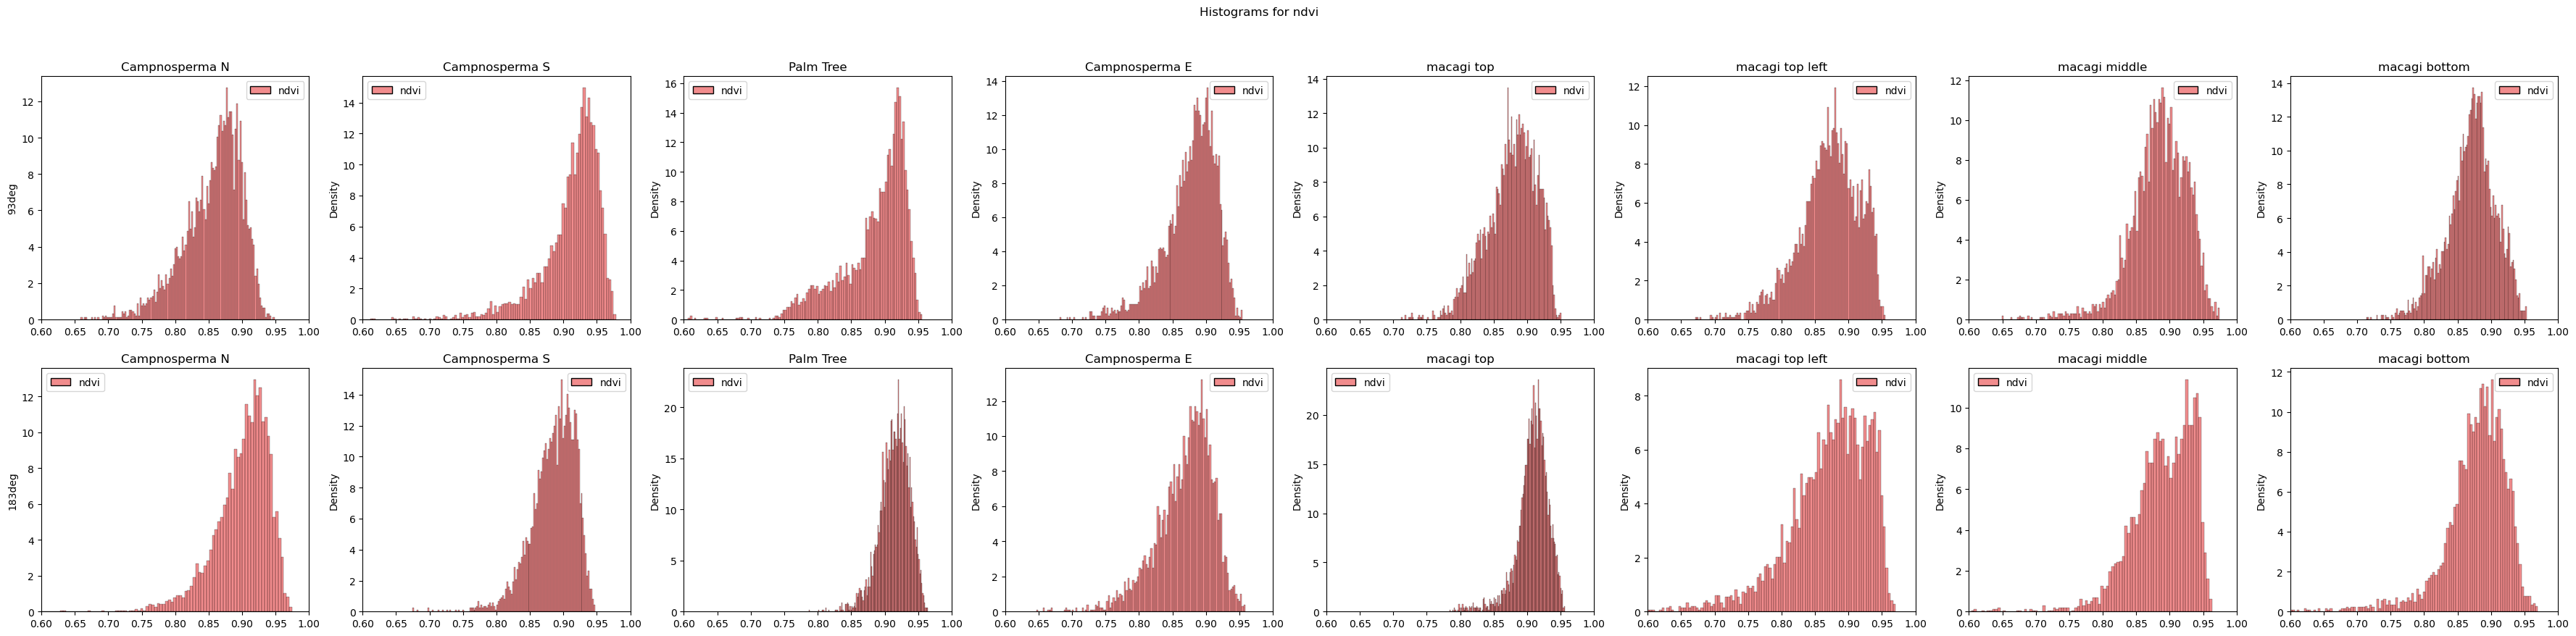

In [347]:
fig = histograms_for_bands(['ndvi'], xlim=(0.6,1))
fig.suptitle("Histograms for ndvi")

## Produce histograms of each band for comparison

In [272]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

In [273]:
df_casuarina['display_name'] =\
    df_casuarina.apply(lambda x: (x['name'], x['src']), axis=1)

In [274]:
df_casuarina_px = df_casuarina.copy()
for band in bands:
    df_casuarina_px[band] = df_casuarina_px['crop']\
        .apply(lambda x: crop_center(x, 64, 64))\
        .apply(lambda x: x[:,:,bands.index(band)].flatten())
df_casuarina_px = df_casuarina_px.drop('crop', axis=1)
df_casuarina_px = df_casuarina_px.explode(bands).reset_index(drop=True)
gc.collect()

49612

  0%|          | 0/9 [00:00<?, ?it/s]

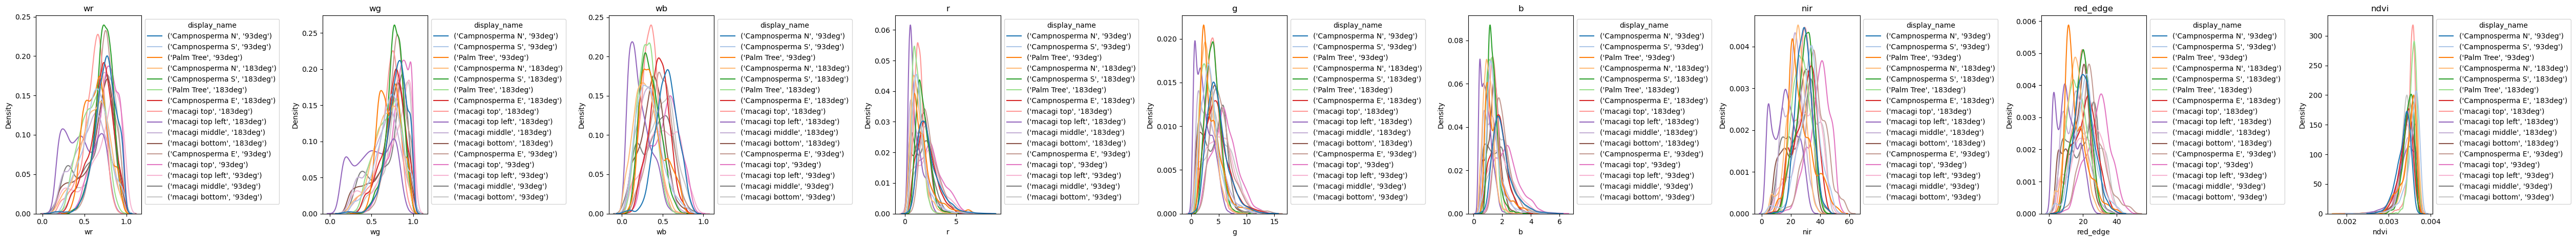

In [281]:
fig, ax = plt.subplots(nrows:=1,
                       ncols:=len(bands),
                       figsize=(5.6*ncols, 4.8*nrows))
for box, band in tqdm(zip(ax.flatten(), bands), total=len(bands)):
    band_px = df_casuarina_px[['name', 'src', 'display_name', band]]
    sns.kdeplot(
        band_px,#.sample(128),
        x=band,
        hue='display_name',
        #bins=128,
        palette='tab20',
        #stat='density',
        #common_norm=False,
        #element='step',
        fill=False,
        ax=box)
    box.set_title(band)
    sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

## Save our bounds

In [349]:
casuarina_bounds.to_csv('casuarina bounds.csv')